In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import Matrix, init_printing, matrix2numpy, diag

In [4]:
assets=pd.read_excel('../data/multi_asset_etf_data.xlsx')

In [5]:
assets

,ticker,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
0,SPY,SPDR S&P 500,ETF,USD,42926953,412799303680,The Trust seeks to achieve its investment obje...
1,EFA,iShares MSCI EAFE ETF,ETF,USD,9234292,48446230528,The fund generally will invest at least 80% of...
2,EEM,iShares MSCI Emerging Index Fun,ETF,USD,21697929,21355970560,The fund generally will invest at least 80% of...
3,PSP,Invesco Global Listed Private E,ETF,USD,2557,214931952,The fund generally will invest at least 90% of...
4,QAI,IQ Hedge MultiIQ Hedge Multi-St,ETF,USD,16734,624121728,"The fund is a ""fund of funds"" which means it i..."
5,HYG,iShares iBoxx $ High Yield Corp,ETF,USD,18515962,14783441920,The underlying index is a rules-based index co...
6,DBC,Invesco DB Commodity Index Trac,ETF,USD,506418,2091483648,The fund pursues its investment objective by i...
7,IYR,iShares U.S. Real Estate ETF,ETF,USD,4115950,2840025600,The fund seeks to track the investment results...
8,IEF,iShares 7-10 Year Treasury Bond,ETF,USD,4696390,28524961792,The underlying index measures the performance ...
9,BWX,SPDR Bloomberg International Tr,ETF,USD,58614,898953088,"The fund generally invests substantially all, ..."


In [6]:
df=pd.read_excel('../data/multi_asset_etf_data.xlsx', sheet_name=3)

In [7]:
df

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,2009-04-30,0.008441,-0.001553,0.155030,0.114637,0.137907,-0.028004,0.295598,0.229650,0.022329,0.098793,-0.018505
1,2009-05-31,0.054143,0.163134,0.159871,0.132389,0.029026,-0.020303,0.023198,0.054363,0.028336,0.058925,0.020437
2,2009-06-30,0.004550,-0.026858,-0.023094,-0.014648,0.032919,-0.006170,-0.025462,0.041443,-0.004035,-0.001254,0.001383
3,2009-07-31,0.031312,0.018595,0.110173,0.100442,0.069217,0.008344,0.105826,0.143274,0.015353,0.074633,0.000906
4,2009-08-31,0.007193,-0.040800,-0.013571,0.044595,-0.017404,0.007199,0.131504,0.032977,-0.004586,0.036504,0.007979
...,...,...,...,...,...,...,...,...,...,...,...,...
168,2023-04-30,-0.005609,-0.010679,-0.011460,0.026266,-0.001076,0.005051,0.006090,0.031522,0.002038,0.012878,-0.002579
169,2023-05-31,-0.029213,-0.067345,-0.027276,-0.043324,-0.015567,-0.017636,-0.043519,-0.022374,-0.009725,0.001363,-0.015214
170,2023-06-30,0.003433,0.024730,0.039240,0.039952,0.013053,-0.017301,0.052634,0.042028,0.017877,0.060051,-0.008147
171,2023-07-31,0.005978,0.083389,0.056579,0.023199,0.007320,-0.010352,0.013613,0.060803,0.015608,0.028898,-0.003425


In [17]:
def calculate_statistics(df):
    res={}
    res_i={}
    for i in df.columns:
        if df[i].dtype=='<M8[ns]':
            pass
        else:
            res_i.update({'mean':np.mean(df[i])*12})
            res_i.update({'volatility':np.std(df[i])*(12**(1/2))})
            res_i.update({'sharpe':res_i['mean']/res_i['volatility']})
            res.update({i:res_i})
            res_i={}
    return res

def calculate_statistics_array(data):
    res_i={}
    res_i.update({'mean':np.mean(data)*12})
    res_i.update({'volatility':np.std(data)*(12**(1/2))})
    res_i.update({'sharpe':res_i['mean']/res_i['volatility']})
    return res_i


def correlation_matrix(df):
    return df.corr()

#Make sure the first column is dates
def tangency_portfolio(df):
    stats=calculate_statistics(df)
    assets=len(df.columns[1:])
    mdf=Matrix(df.iloc[:,1:].cov())
    vect1=Matrix([1]*assets)
    mean=[]
    for i in stats:
        mean.append(stats[i]['mean'])
    vectmean=Matrix(mean)
    sigma_inv=mdf.inv()
    wt=(1/((vect1.T@sigma_inv@vectmean)[0,0]))*(sigma_inv@vectmean)

    tickers=[]
    for i in stats:
        tickers.append(i)
    tan_port=pd.DataFrame()
    tan_port['tickers']=tickers
    tan_port['Tangent Weights']=0
    for i in range(len(tan_port)):
        tan_port.loc[i,'Tangent Weights']=wt[i]
    
    tan_port.set_index('tickers', inplace=True,drop=True)

    return tan_port

In [9]:
stats=calculate_statistics(df)

In [10]:
pd.DataFrame(stats)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
mean,-0.001843,0.025443,0.064887,0.081597,0.064168,0.014269,0.129473,0.079938,0.018974,0.143727,0.022321
volatility,0.083117,0.178457,0.195962,0.165511,0.088896,0.062224,0.186560,0.226728,0.050663,0.147251,0.051380
sharpe,-0.022177,0.142574,0.331121,0.493000,0.721835,0.229316,0.694005,0.352573,0.374524,0.976070,0.434424


In [11]:
df.corr()

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,1.000000,-0.160656,0.031107,-0.111810,-0.088968,-0.212007,-0.153008,-0.185720,-0.113139,-0.108098,-0.077286,-0.149289
BWX,-0.160656,1.000000,0.349773,0.647614,0.621662,0.557653,0.434472,0.453534,0.524870,0.668045,0.465713,0.617099
DBC,0.031107,0.349773,1.000000,0.565654,0.581865,0.473208,-0.321738,0.318314,0.496057,0.547936,0.509886,0.136668
EEM,-0.111810,0.647614,0.565654,1.000000,0.851579,0.726041,-0.102347,0.621814,0.771677,0.807245,0.734556,0.302729
EFA,-0.088968,0.621662,0.581865,0.851579,1.000000,0.771463,-0.132331,0.697875,0.891929,0.853674,0.871641,0.287476
HYG,-0.212007,0.557653,0.473208,0.726041,0.771463,1.000000,-0.008598,0.757649,0.823823,0.768756,0.770353,0.365939
IEF,-0.153008,0.434472,-0.321738,-0.102347,-0.132331,-0.008598,1.000000,0.073622,-0.118676,0.055667,-0.155696,0.706078
IYR,-0.185720,0.453534,0.318314,0.621814,0.697875,0.757649,0.073622,1.000000,0.760158,0.655963,0.753610,0.397166
PSP,-0.113139,0.524870,0.496057,0.771677,0.891929,0.823823,-0.118676,0.760158,1.000000,0.838287,0.895729,0.320913
QAI,-0.108098,0.668045,0.547936,0.807245,0.853674,0.768756,0.055667,0.655963,0.838287,1.000000,0.840989,0.459712


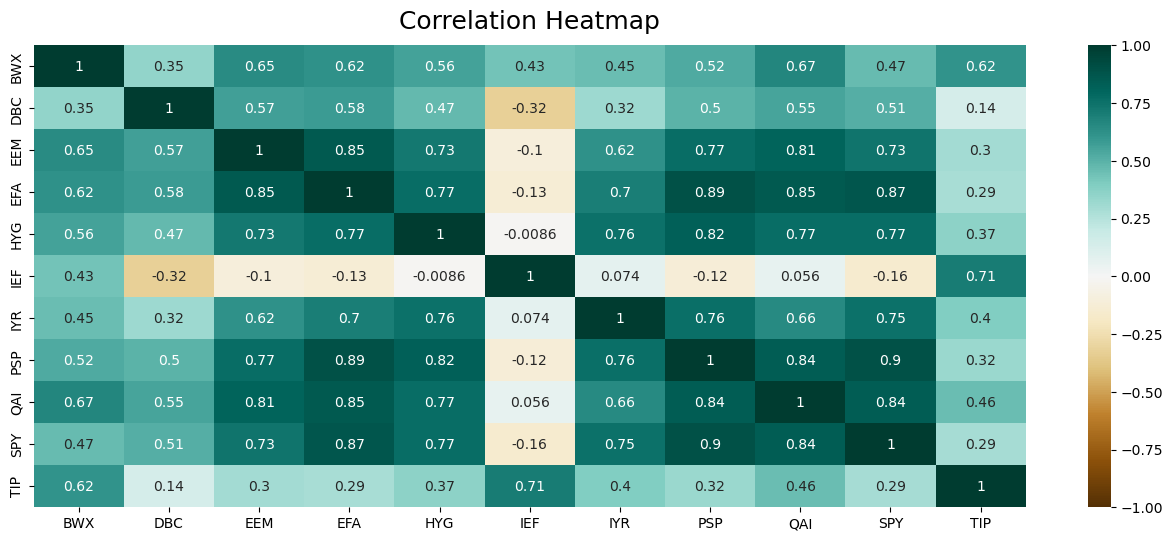

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.iloc[:,1:].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [15]:
wt=tangency_portfolio(df)
wt
# tickers=[]
# stats=calculate_statistics(df)
# for i in stats:
#     tickers.append(i)
# tan_port=pd.DataFrame()
# tan_port['tickers']=tickers
# tan_port['weights']=0
# for i in range(len(tan_port)):
#     tan_port.loc[i,'weights']=wt[i]
# tan_port

,weights
tickers,
BWX,-1.46497413716166
DBC,0.0284364640939001
EEM,0.261027687851795
EFA,0.452913993941430
HYG,1.52894242097805
IEF,1.89399164893837
IYR,-0.242771990489945
PSP,-1.27105459892735
QAI,-3.13344543918127


In [ ]:
portfolio=np.zeros((len(df)))
for i in range(1,len(df.columns)):
    portfolio+=np.array(df.iloc[:,i])*float(wt[i-1])
stats_tangency=calculate_statistics_array(portfolio)
stats_tangency

#### Change if new TIPS

##### TIPS are dropped

In [ ]:
df_notip=df.drop(columns=['TIP']).copy()

In [ ]:
wt=tangency_portfolio(df_notip)
tickers=[]
stats=calculate_statistics(df_notip)
for i in stats:
    tickers.append(i)
tan_port=pd.DataFrame()
tan_port['tickers']=tickers
tan_port['weights']=0
for i in range(len(tan_port)):
    tan_port.loc[i,'weights']=wt[i]
tan_port

In [ ]:
portfolio=np.zeros((len(df_notip)))
for i in range(1,len(df_notip.columns)):
    portfolio+=np.array(df_notip.iloc[:,i])*float(wt[i-1])
stats_tangency=calculate_statistics_array(portfolio)
stats_tangency

##### TIPS + 0.0012

In [ ]:
df_tip12=df.copy()
df_tip12['TIP']+=0.0012

In [ ]:
wt=tangency_portfolio(df_tip12)
tickers=[]
stats=calculate_statistics(df_tip12)
for i in stats:
    tickers.append(i)
tan_port=pd.DataFrame()
tan_port['tickers']=tickers
tan_port['weights']=0
for i in range(len(tan_port)):
    tan_port.loc[i,'weights']=wt[i]
tan_port

In [ ]:
portfolio=np.zeros((len(df_tip12)))
for i in range(1,len(df_tip12.columns)):
    portfolio+=np.array(df_tip12.iloc[:,i])*float(wt[i-1])
stats_tangency=calculate_statistics_array(portfolio)
stats_tangency

### Part 3

In [ ]:
mut=0.015

mean=[]
for i in df.columns[1:]:
    mean.append(df[i].mean())
vectmean=Matrix(mean)

In [ ]:
EWw=Matrix([1/len(df.columns[1:])]*len(df.columns[1:]))
EWw*=mut/(EWw.T@vectmean)[0]

In [ ]:
variances_inv=[]
for i in df.columns[1:]:
    variances_inv.append(1/(df[i].var()))

RPw=Matrix(variances_inv)
RPw*=mut/(RPw.T@vectmean)[0]

In [ ]:
sigma=df.iloc[:,1:].cov()
sigma=Matrix(sigma)
sigma_diag=Matrix(np.diag(np.array(sigma.diagonal())[0]))
sigmatilda=(sigma+sigma_diag)/2
REGw=sigmatilda.inv()@vectmean
REGw*=mut/(REGw.T@vectmean)[0]

In [ ]:
wt=tangency_portfolio(df)
wt*=mut/(wt.T@vectmean)[0]

In [ ]:
res3={}
weight_vects=['wt','EWw','RPw','REGw']
tdata=Matrix(df.iloc[:,1:])
for i,ii in enumerate([wt,EWw,RPw,REGw]):
    tarray=np.array(((tdata@ii).T),dtype='float')
    res3.update({weight_vects[i]:calculate_statistics_array(tarray)})
pd.DataFrame(res3)

#### Part 4

In [ ]:
mut_month=0.015
df_2021=df[df['Date']<'2021'].copy()
wt2021=tangency_portfolio(df_2021)
wt2021*=mut_month/(wt2021.T@Matrix(df_2021.iloc[:,1:].mean()))[0]
tarray=np.array(((Matrix(df_2021.iloc[:,1:])@wt2021).T),dtype='float')[0]
calculate_statistics_array(tarray)


In [ ]:
df_2022=df[df['Date']>='2021'].copy()
tarray=np.array(((Matrix(df_2022.iloc[:,1:])@wt2021).T),dtype='float')[0]
calculate_statistics_array(tarray)

In [ ]:
res_array=np.array(())
for i in range(2013,2023):
    tdf=df[df['Date']<str(i+1)].copy()
    # tdf=tdf[tdf['Date']>str(i)]
    twt=tangency_portfolio(tdf)
    twt*=mut_month/(twt.T@Matrix(tdf.iloc[:,1:].mean()))[0]
    ttdf=df[df['Date']<str(i+2)].copy()
    ttdf=ttdf[ttdf['Date']>str(i+1)].copy()
    tarray=np.array(((Matrix(ttdf.iloc[:,1:])@twt).T),dtype='float')[0]
    res_array=np.concatenate((res_array,tarray),axis=0)
calculate_statistics_array(res_array)

#### Part 5